In [1338]:
import matplotlib.pyplot as plt
from scipy.linalg import expm
import scipy.integrate as integrate
from scipy.linalg import null_space
from sympy import Matrix, simplify, exp
from sympy import Symbol 
import numpy as np
import control Задание 1. Возьмите матрицы A и B из таблицы 1 в соответствии с вашим вариантом и рассмотрите систему
x˙ = Ax + Bu.
Выполните следующие шаги и приведите в отчёте результаты всех вычислений, схемы
моделирования, графики и выводы:
1. Найдите матрицу управляемости системы, определите её ранг, сделайте вывод об
управляемости системы.
2. Найдите собственные числа матрицы A и жорданову форму системы. Определите
управляемость каждого собственного числа двумя способами: на основе жордановой формы и с помощью рангового критерия.
3. Принадлежит ли точка x1 из таблицы 1 управляемому подпространству системы?
4. Найдите Грамиан управляемости системы относительно времени t1 = 3, вычислите его собственные числа.
5. Найдите управление, переводящее систему из x(0) = 0 в x(t1) = x1 за время t1 = 3.
6. Выполните моделирование системы с рассчитанным управлением, постройте графики компонент вектора x(t) до времени t1 = 3, а также график сигнала управления u(t).
Задание 2. Возьмите матрицы A и B из таблицы 
import sympy
import os

In [1339]:
A = [
    [13, -11, 14],
    [10, -7, 10],
    [-10, 6, -11]
]

B = [[-5, -3, 5]]
x1 = [[-3, -1, 1]]

In [1340]:
A = np.array(A)
B = np.array(B).reshape(-1, 1)
x1 = np.array(x1).reshape(-1, 1)

In [1341]:
def get_jordan_cells(A):
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    
    n = A.shape[0]
    jordan_cells_poses = []
    jordan_cells = []
    current_jordan_cell_size = 1
    current_jordan_cell_pos = 0

    while current_jordan_cell_pos + current_jordan_cell_size < n:
        
        jordan_cell_down_element_pos = current_jordan_cell_pos + current_jordan_cell_size - 1
        if A[jordan_cell_down_element_pos, jordan_cell_down_element_pos + 1] == 1 or A[jordan_cell_down_element_pos + 1, jordan_cell_down_element_pos] == 1:
            current_jordan_cell_size += 1
        else:
            jordan_cells_poses.append((current_jordan_cell_pos, current_jordan_cell_size))
            current_jordan_cell_pos += current_jordan_cell_size
            current_jordan_cell_size = 1

    jordan_cells_poses.append((current_jordan_cell_pos, current_jordan_cell_size))
    
    for pos in jordan_cells_poses:
        jordan_cells.append(A[pos[0]:pos[0]+pos[1], pos[0]:pos[0]+pos[1]])

    return jordan_cells_poses, jordan_cells

In [1342]:
def get_control_matrix(A, B):
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == B.shape[0]

    n = A.shape[0]
    U = np.zeros((n, 0))
    for i in range(n):
        new_column = (np.linalg.matrix_power(A, i) @ B).reshape((-1, 1))
        U = np.concatenate((U, new_column), axis=1)

    return U
    

In [1343]:
def check_eigenvalues_controllable(A, B, method = 'rank_criteria') -> np.array:
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == B.shape[0]
    
    n = A.shape[0]
    is_controllable = []

    if method == 'rank_criteria':
        eigen_values, _ = np.linalg.eig(A)
        for eigen_value in eigen_values:
            M = np.concatenate((A - eigen_value * np.eye(n), B.reshape(-1, 1)), axis=1)
            is_controllable.append(np.linalg.matrix_rank(M) == n)
    elif method == 'jordan_form':
        P, J = Matrix(A).jordan_form()
        jordan_cells_poses, _ = get_jordan_cells(J)
        B_jordan_form = np.array(P.inv() @ B).T.flatten()
        print('jordan_form ', B_jordan_form)
        for jordan_cells_pose in jordan_cells_poses:
            down_stroke_id = jordan_cells_pose[0] + jordan_cells_pose[1] - 1
            is_controllable.append(True if B_jordan_form[down_stroke_id] != 0 else False) 
    else:
        raise NotImplementedError

    return np.array(is_controllable)

In [1344]:
def check_system_controllable(A, B, method = 'rank_criteria'):
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == B.shape[0]
    
    is_controllable = None
    n = A.shape[0]
    if method == 'rank_criteria':
        U = get_control_matrix(A, B)
        is_controllable = np.linalg.matrix_rank(U) == n
    elif method == 'eigen_values_criteria':
        is_controllable = True
        _, J = Matrix(A).jordan_form()
        _, jordan_cells = get_jordan_cells(J)
       
        for i in range(len(jordan_cells)):
            for j in range(len(jordan_cells)):
                if i != j and np.array_equal(jordan_cells[i], jordan_cells[j]):
                    is_controllable = False
        
        is_controllable = is_controllable and np.all(check_eigenvalues_controllable(A, B))
    else:
        raise NotImplementedError
    
    return is_controllable

In [1345]:
def check_is_state_controllable(A, B, x):
    U = get_control_matrix(A, B)
    return np.linalg.matrix_rank(U) == np.linalg.matrix_rank(np.concatenate((U, x.reshape(-1, 1)), axis=1))
    

In [1346]:
def get_controllability_gramian(A, B, t1):
    controllability_gramian = integrate.quad_vec(lambda x: expm(A*x) @ B @ B.T @ expm(A.T*x), 0, t1)[0] 

    return controllability_gramian

In [1347]:
def get_control(A, B, t1, x1, P = None):
    if P is None:
        P = get_controllability_gramian(A, B, t1)
    
    u = lambda t: (B.T @ expm(A.T*(t1 - t)) @ np.linalg.pinv(P) @  x1)[0][0]

    t=Symbol('t') 
    u_t = simplify(B.T @ simplify(exp(Matrix(A.T*(t1 - t)))) @ np.linalg.pinv(P) @  x1)
    print("U(t) ", u_t)
    t = np.linspace(0, t1, 100)

    U = []
    for step in t:
        U.append(u(step))

    return U, t

Tests:

In [1348]:
assert np.array_equal(get_control_matrix(A, B).shape, np.array((A.shape[0], A.shape[0]*B.shape[1])))
assert np.array_equal(check_eigenvalues_controllable(A, B, method = 'rank_criteria'), check_eigenvalues_controllable(A, B, method = 'jordan_form'))
assert check_system_controllable(A, B, method = 'rank_criteria') == check_system_controllable(A, B, method = 'eigen_values_criteria')
assert check_is_state_controllable(A, B, np.zeros(A.shape[0])) == True
A_test = np.array([
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])
B_test = np.array([
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1],
])
P_test = np.array([
    [2./3., 1./3., 1./2., 1./2.],
    [1./3., 1./3., 0, 1./2.],
    [1./2., 0., 1., 0.],
    [1./2., 1./2., 0., 1.],
])
x1_test = np.array([[1, 1, 0, 0]]).reshape(-1, 1)
assert np.linalg.norm(get_controllability_gramian(A_test, B_test, t1=1) - P_test) < 0.001

jordan_form  [2 3/2 - 3*I/2 3/2 + 3*I/2]


In [1349]:
def plot_result(A, B, U, t):
    ss = control.ss(A, B, A * 0, B * 0)
    output = control.forced_response(ss, X0=[0,0,0], U=U, T=t).states

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(3):
        axs[i//2, i % 2].plot(t, output[i], linewidth=4)
        axs[i//2, i % 2].scatter(t[-1], x1[i], color='r', linewidth=4, label='goal')
        axs[i//2, i % 2].set_title(f'x_{i} = x_{i}(t)', fontsize=12)
        axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
        axs[i//2, i % 2].grid(True)
        axs[i//2, i % 2].legend()
        
        
    axs[1, 1].plot(t, np.array(U).reshape(-1), linewidth=4)
    axs[1, 1].set_title(f'u = u(t)', fontsize=12)
    axs[1, 1].set_xlabel(f"t, [c]", fontsize=12)
    axs[1, 1].grid(True)
    # plt.savefig(f'{file_name}.jpg') 

Lab:

In [1350]:
get_control_matrix(A, B)

array([[ -5.,  38., -59.],
       [ -3.,  21.,   3.],
       [  5., -23.,  -1.]])

In [1351]:
np.linalg.eig(A)

EigResult(eigenvalues=array([-2.+5.j, -2.-5.j, -1.+0.j]), eigenvectors=array([[-7.45355992e-01+0.j       , -7.45355992e-01-0.j       ,
        -7.07106781e-01+0.j       ],
       [-4.47213595e-01+0.1490712j, -4.47213595e-01-0.1490712j,
         2.10942375e-15+0.j       ],
       [ 4.47213595e-01-0.1490712j,  4.47213595e-01+0.1490712j,
         7.07106781e-01+0.j       ]]))

In [1352]:
_, J = Matrix(A).jordan_form()
J

Matrix([
[-1,        0,        0],
[ 0, -2 - 5*I,        0],
[ 0,        0, -2 + 5*I]])

In [1353]:
check_system_controllable(A, B)

True

In [1354]:
check_eigenvalues_controllable(A, B)

array([ True,  True,  True])

In [1355]:
check_eigenvalues_controllable(A, B, method = 'jordan_form')

jordan_form  [2 3/2 - 3*I/2 3/2 + 3*I/2]


array([ True,  True,  True])

In [1356]:
check_is_state_controllable(A, B, x1)

True

In [1357]:
expm(A*1) @ B @ B.reshape(1, -1) @ expm(A.T*1)

array([[ 2.65554766,  0.82212141, -2.02110313],
       [ 0.82212141,  0.2545176 , -0.62570602],
       [-2.02110313, -0.62570602,  1.53823558]])

In [1358]:
P = get_controllability_gramian(A, B, t1=3)

In [1359]:
P

array([[ 3.13226347,  1.70315356, -2.4629419 ],
       [ 1.70315356,  1.47412296, -1.12126199],
       [-2.4629419 , -1.12126199,  2.76344352]])

In [1360]:
P, np.linalg.eig(P)[0]

(array([[ 3.13226347,  1.70315356, -2.4629419 ],
        [ 1.70315356,  1.47412296, -1.12126199],
        [-2.4629419 , -1.12126199,  2.76344352]]),
 array([6.26534005, 0.23256956, 0.87192033]))

U(t)  Matrix([[(-1.0*(0.640911796264675 + 5.00645739178454*I)*exp(10*I*(t - 3)) + 3.17924542021937*exp(-t + 5*I*t + 3 - 15*I) - 0.640911796264675 + 5.00645739178454*I)*exp(2*t - 5*I*t - 6 + 15*I)]])


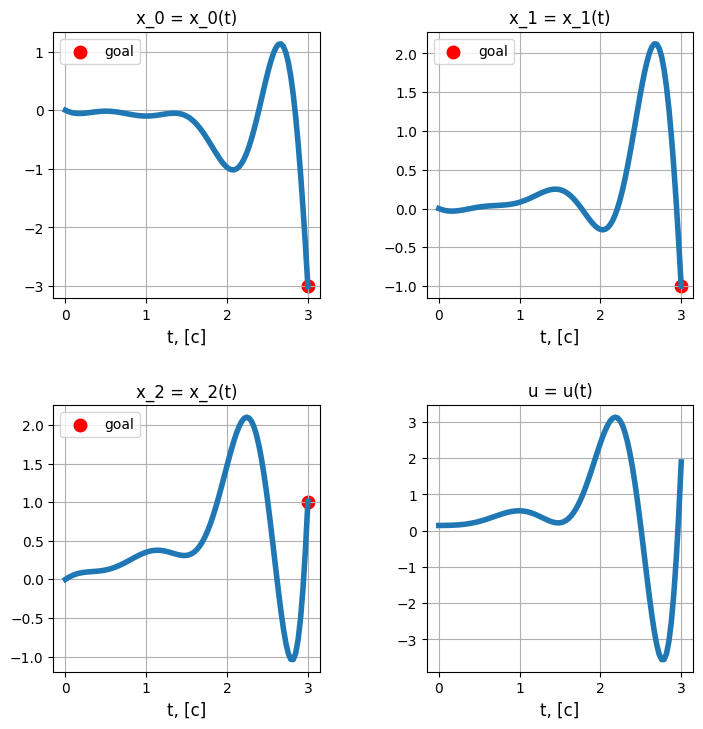

In [1361]:
U, t = get_control(A, B, 3, x1)
plot_result(A, B, U, t)

# Задание №2

In [1362]:
A = [
    [13, -11, 14],
    [10, -7, 10],
    [-10, 6, -11]
]

B = [[1, -1, 1]]
x1 = [[-3, -1, 1]]
x2 = [[-6, -1, 4]]

A = np.array(A)
B = np.array(B).reshape(-1, 1)
x1 = np.array(x1).reshape(-1, 1)
x2 = np.array(x2).reshape(-1, 1)

In [1363]:
check_is_state_controllable(A, B, x1)

True

In [1364]:
check_is_state_controllable(A, B, x2)

False

In [1365]:
U = get_control_matrix(A, B)

In [1366]:
np.linalg.matrix_rank(U)

2

In [1367]:
check_system_controllable(A, B)

False

In [1368]:
np.linalg.eig(A)[0]

array([-2.+5.j, -2.-5.j, -1.+0.j])

In [1369]:
check_eigenvalues_controllable(A, B)

array([ True,  True, False])

In [1370]:
_, J = Matrix(A).jordan_form()
J

Matrix([
[-1,        0,        0],
[ 0, -2 - 5*I,        0],
[ 0,        0, -2 + 5*I]])

In [1371]:
check_eigenvalues_controllable(A, B, method = 'jordan_form')

jordan_form  [0 1/2 - 5*I/2 1/2 + 5*I/2]


array([False,  True,  True])

In [1372]:
P = get_controllability_gramian(A, B, t1=3)
P, np.linalg.eig(P)[0]

(array([[ 7.72841689,  4.03877436, -4.03877436],
        [ 4.03877436,  2.40515848, -2.40515848],
        [-4.03877436, -2.40515848,  2.40515848]]),
 array([ 1.21644686e+01,  3.74265278e-01, -9.86076132e-32]))

In [1373]:
_, J = Matrix(P).jordan_form()
J

Matrix([
[0,                 0,                0],
[0, 0.374265277643643,                0],
[0,                 0, 12.1644685702871]])

In [1374]:
np.linalg.inv(P)

array([[ 1.05657667e+00, -5.17570423e+00, -3.36420775e+00],
       [-2.02421770e+00, -2.25179981e+15, -2.25179981e+15],
       [-2.50000000e-01, -2.25179981e+15, -2.25179981e+15]])

U(t)  Matrix([[(-1.0*(1.66155111904312 + 0.763074346078765*I)*exp(10*I*(t - 3)) - 1.66155111904312 + 0.763074346078765*I)*exp(2*t - 5*I*t - 6 + 15*I)]])


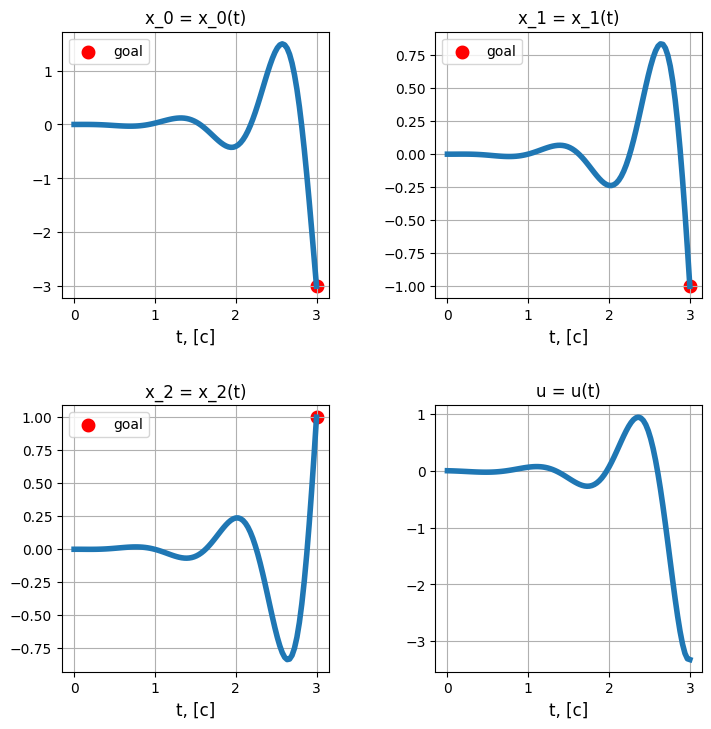

In [1375]:
U, t = get_control(A, B, 3, x1)
plot_result(A, B, U, t)

# Задание №3

In [1376]:
A = np.array([
    [-13, 2, -12],
    [-6, -1, -8],
    [8, -4, 5]
])
C = np.array([[9, -2, 9]])
y = lambda t: 21*np.exp(-5*t)*np.cos(2*t) - 7*np.exp(-5*t)*np.sin(2*t)

In [1377]:
def get_observation_matrix(A, C):
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == C.shape[1]

    n = A.shape[0]
    U = np.zeros((0, n))
    for i in range(n):
        new_column = (C @ np.linalg.matrix_power(A, i))
        U = np.concatenate((U, new_column))

    return U
    

In [1378]:
def check_eigenvalues_observable(A, C, method = 'rank_criteria') -> np.array:
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == C.shape[1]
    
    n = A.shape[0]
    is_observable = None

    if method == 'rank_criteria':
        is_observable = []
        eigen_values, _ = np.linalg.eig(A)
        for eigen_value in eigen_values:
            M = np.concatenate((A - eigen_value * np.eye(n), C))
            is_observable.append(np.linalg.matrix_rank(M) == n)
    elif method == 'jordan_form':
        is_observable = []
        P, J = Matrix(A).jordan_form()
        jordan_cells_poses, _ = get_jordan_cells(J)
        C_jordan_form = C @ P
        print("C_jordan_form: ", C_jordan_form)
        for jordan_cells_pose in jordan_cells_poses:
            is_observable.append(True if C_jordan_form[jordan_cells_pose[0]] != 0 else False) 
    else:
        raise NotImplementedError

    return np.array(is_observable)

In [1379]:
def check_system_observable(A, B, method = 'rank_criteria'):
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == C.shape[1]
    
    is_observable = None
    n = A.shape[0]
    if method == 'rank_criteria':
        V = get_observation_matrix(A, C)
        is_observable = np.linalg.matrix_rank(V) == n
    elif method == 'eigen_values_criteria':
        is_observable = True
        _, J = Matrix(A).jordan_form()
        _, jordan_cells = get_jordan_cells(J)
       
        for i in range(len(jordan_cells)):
            for j in range(len(jordan_cells)):
                if i != j and np.array_equal(jordan_cells[i], jordan_cells[j]):
                    is_observable = False
        
        is_observable = is_observable and np.all(check_eigenvalues_observable(A, B))
    else:
        raise NotImplementedError
    
    return is_observable

In [1380]:
def get_observability_gramian(A, C, t1):
    observability_gramian = integrate.quad_vec(lambda x: expm(A.T*x) @ C.T @ C @ expm(A*x), 0, t1)[0] 

    return observability_gramian

In [1381]:
def get_init_state(A, C, y, t1):
    Q = get_observability_gramian(A, C, t1)
    init_state = np.linalg.pinv(Q) @ integrate.quad_vec(lambda x: expm(A.T*x) @ C.T * y(x), 0, t1)[0]

    return init_state

In [1382]:
def get_restored_state(A, init_state, time):
    X = []
    for t in time:
        X.append(expm(A*t) @ init_state)

    return X

In [1383]:
def plot_task3(A, C, y, times):

    x0 = get_init_state(A, C, y, times[-1])
    ss = control.ss(A, A * 0, C, C * 0)
    res = control.forced_response(ss, X0=x0, U=0, T=times)
    output = res.states

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(3):
        axs[i//2, i % 2].plot(times, output[i], linewidth=4)
        axs[i//2, i % 2].scatter(0, x0[i], color='r', linewidth=4, label='initial')
        axs[i//2, i % 2].set_title(f'x_{i} = x_{i}(t)', fontsize=12)
        axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
        axs[i//2, i % 2].grid(True)
        axs[i//2, i % 2].legend()
        
        
    axs[1, 1].plot(times, res.outputs.reshape(-1), linewidth=4)
    axs[1, 1].scatter(0, C @ x0, color='r', linewidth=4, label='initial')
    axs[1, 1].set_title(f'y = y(t)', fontsize=12)
    axs[1, 1].set_xlabel(f"t, [c]", fontsize=12)
    axs[1, 1].grid(True)
    return x0

Tests:

In [1384]:
V = get_observation_matrix(A, C)
print("Observation_Matrix: ", V)
print("rank(V) = ", np.linalg.matrix_rank(V))
print("A eigen values: ", np.linalg.eig(A)[0])
print("J: ", Matrix(A).jordan_form()[1])
print(check_eigenvalues_observable(A, C, method='jordan_form'))
print(check_eigenvalues_observable(A, C))
print(check_system_observable(A, C))
Q = get_observability_gramian(A, C, 3)
print("Observability gramian", Q, np.linalg.eig(Q)[0])
x0 = get_init_state(A, C, y, 3)
print("Init_state: ", x0)

Observation_Matrix:  [[  9.  -2.   9.]
 [-33. -16. -47.]
 [149. 138. 289.]]
rank(V) =  3
A eigen values:  [ 1.+0.j -5.+2.j -5.-2.j]
J:  Matrix([[1, 0, 0], [0, -5 - 2*I, 0], [0, 0, -5 + 2*I]])
C_jordan_form:  Matrix([[2, -7/2 - 7*I/2, -7/2 + 7*I/2]])
[ True  True  True]
[ True  True  True]
True
Observability gramian [[ 815.01961811 -809.9023922   812.77479397]
 [-809.9023922   807.99551112 -808.16446462]
 [ 812.77479397 -808.16446462  810.86790087]] [2.43186473e+03 1.45198513e-01 1.87310428e+00]
Init_state:  [[ 5.]
 [ 3.]
 [-2.]]


In [1385]:
t = np.linspace(0, 3, 100)
X = get_restored_state(A, x0, t)

array([[ 5.],
       [ 3.],
       [-2.]])

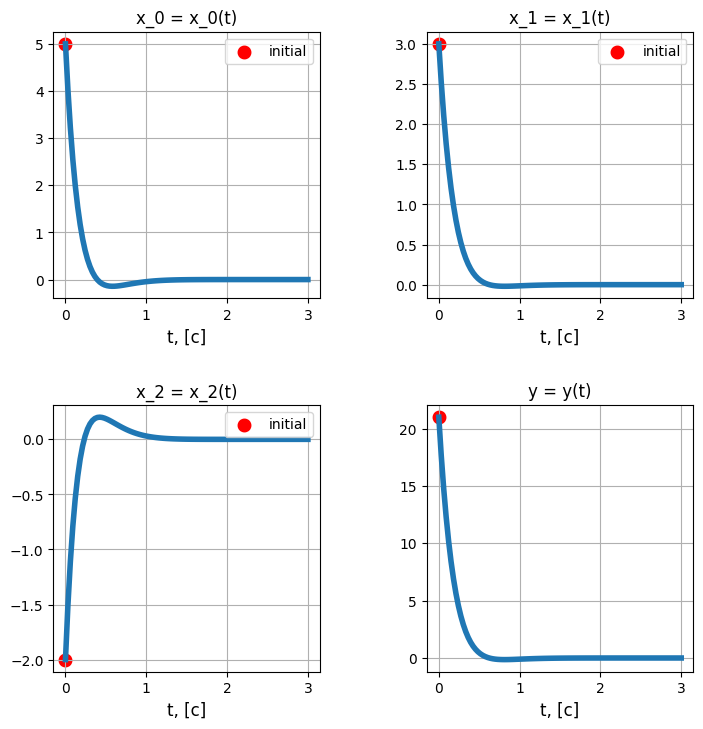

In [1386]:
plot_task3(A, C, y, t)

# Задание 4

In [1387]:
A = np.array([
    [-13, 2, -12],
    [-6, -1, -8],
    [8, -4, 5]
])
C = np.array([[7, 0, 7]])
y = lambda t: 21*np.exp(-5*t)*np.cos(2*t) - 7*np.exp(-5*t)*np.sin(2*t)

In [1388]:
V = get_observation_matrix(A, C)
print("Observation_Matrix: ", V)
print("rank(V) = ", np.linalg.matrix_rank(V))
print("A eigen values: ", np.linalg.eig(A)[0])
print("J: ", Matrix(A).jordan_form()[1])
print(check_eigenvalues_observable(A, C, method='jordan_form'))
print(check_eigenvalues_observable(A, C))
print(check_system_observable(A, C))
Q = get_observability_gramian(A, C, 3)
print("Observability gramian", Q, np.linalg.eig(Q)[0])
x0 = get_init_state(A, C, y, 3)
print("Init_state: ", x0)

Observation_Matrix:  [[  7.   0.   7.]
 [-35. -14. -49.]
 [147. 140. 287.]]
rank(V) =  2
A eigen values:  [ 1.+0.j -5.+2.j -5.-2.j]
J:  Matrix([[1, 0, 0], [0, -5 - 2*I, 0], [0, 0, -5 + 2*I]])
C_jordan_form:  Matrix([[0, -7/2 - 7*I/2, -7/2 + 7*I/2]])
[False  True  True]
[False  True  True]
False
Observability gramian [[ 4.56206897 -0.84482759  3.71724138]
 [-0.84482759  0.33793103 -0.50689655]
 [ 3.71724138 -0.50689655  3.21034483]] [7.79156509e+00 2.80488345e-16 3.18779741e-01]
Init_state:  [[ 1.66666667]
 [-0.33333333]
 [ 1.33333333]]


In [1389]:
Matrix(A).jordan_form()[1]

Matrix([
[1,        0,        0],
[0, -5 - 2*I,        0],
[0,        0, -5 + 2*I]])

In [1390]:
np.linalg.eig(Q)[0]

array([7.79156509e+00, 2.80488345e-16, 3.18779741e-01])

In [1391]:
null_space(V)

array([[-0.57735027],
       [-0.57735027],
       [ 0.57735027]])

In [1392]:
V@np.array([[2*-0.57735027], [2*-0.57735027], [0.57735027]])

array([[  -4.04145189],
       [  28.29016323],
       [-165.69952749]])